In [1]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
import os
print(sys.version)
print(keras.__version__)
print(tf.__version__)

3.6.0 (default, Jul 21 2017, 18:38:06) 
[GCC 4.8.4]
2.0.6
1.2.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [6]:
img = load_img('train/cat/file0000.png')

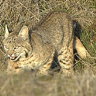

In [7]:
img

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [9]:
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 5000 images belonging to 10 classes.


In [10]:
keras.backend.image_data_format()

'channels_last'

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Nadam

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [23]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validate',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [24]:
predict_datagen = ImageDataGenerator(rescale=1./255)
predict_generator = predict_datagen.flow_from_directory(
        'validate',
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical')

Found 3000 images belonging to 1 classes.


In [50]:
from sklearn.model_selection import train_test_split 
def prepTest(sdirectory, tdirectory, test_size=0.20):
    for c in os.listdir(sdirectory):
        files = os.listdir(os.path.join(sdirectory,c))
        train,test = train_test_split(files, test_size = test_size)
        for file in train:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'train',c,file))
        for file in test:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'validate',c,file))

In [51]:
prepTest('train','data')

In [6]:
class PlotLosses(keras.callbacks.Callback):
    from IPython.display import clear_output
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        from IPython.display import clear_output
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

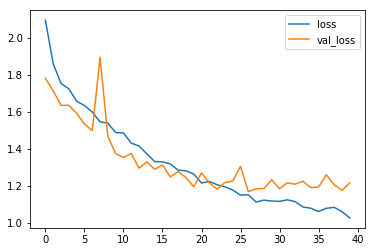

250/250 [==============================] - 19s - loss: 1.0280 - acc: 0.6018 - val_loss: 1.2175 - val_acc: 0.5700


In [25]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=4000 / batch_size,
        epochs=40,
        validation_data=validation_generator,
        callbacks=[plot_losses],
        validation_steps=1000 / batch_size)

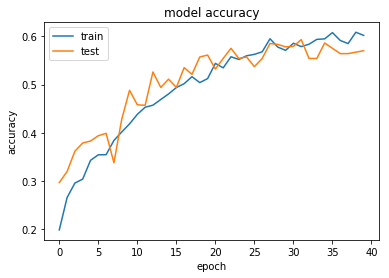

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

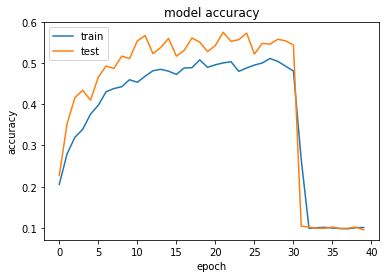

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

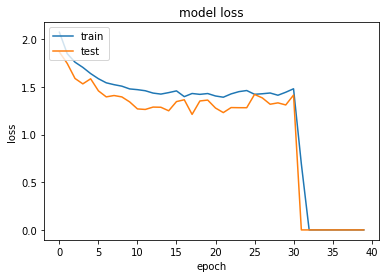

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
predicted = model.predict_generator(predict_generator, 3000 / batch_size)

In [28]:
predicted

array([[  7.31505966e-03,   1.60002819e-04,   4.05788114e-06, ...,
          3.00281215e-07,   7.05761492e-01,   1.23608694e-03],
       [  1.24757793e-09,   4.34427511e-06,   2.01610555e-06, ...,
          2.54403189e-04,   4.88241348e-12,   4.63297454e-07],
       [  2.83523659e-05,   2.64302685e-06,   1.56399347e-02, ...,
          8.10675138e-11,   2.20622756e-02,   2.23416742e-02],
       ..., 
       [  2.62134608e-06,   9.24957320e-02,   3.69429699e-06, ...,
          3.68711352e-02,   4.47977385e-07,   4.55391046e-07],
       [  2.79584140e-01,   5.96051541e-10,   4.36959781e-05, ...,
          4.11327092e-12,   1.19819142e-01,   2.76004721e-04],
       [  6.36079073e-01,   4.16735973e-04,   1.04312552e-02, ...,
          1.02681697e-04,   1.51418326e-02,   7.92462528e-02]], dtype=float32)

## Prediction

In [39]:
import re
import pandas as pd
output = pd.DataFrame({
            'uid': [re.match(r'validate/(.*).png',f).group(1) for f in predict_generator.filenames],
            'class': predicted[0]})
 #[re.match(r'validate/(.*).png',f).group(1) for f in predict_generator.filenames]
#re.match(r'validate/(.*).png','validate/ship-file0280.png').group(1)
#predict_generator.filenames

ValueError: arrays must all be same length

In [41]:
predicted[0]

array([  7.31505966e-03,   1.60002819e-04,   4.05788114e-06,
         4.79782648e-05,   3.92985239e-05,   1.53431592e-05,
         2.73929572e-07,   3.00281215e-07,   7.05761492e-01,
         1.23608694e-03], dtype=float32)